In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from math import e
from marchMadnessBracket.torch_bracket import *
from blitz.modules import BayesianLinear
from blitz.utils import variational_estimator

from marchMadnessBracket.data.bracket_2021 import teams, human_picks
from marchMadnessBracket.utils import realistic_game_logisitic, color_fader,r_squared
import numpy as np
import matplotlib as mpl
'''plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
'''

import pickle

In [2]:
ratings = []
names = []
for team in teams:
    ratings.append(team.rating)
    names.append(team.name)

In [3]:
TB = TorchBracket(teams)

<function matplotlib.pyplot.legend(*args, **kwargs)>

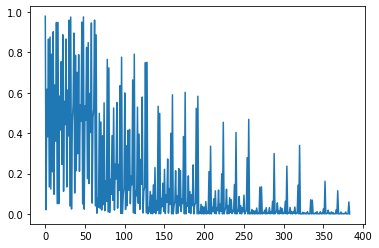

In [4]:
prob = TB.prob_multi_level_flat()
prob = prob.detach().numpy()
plt.plot(prob)
plt.legend

In [5]:
target = make_target_from_human_picks(human_picks,names)

In [6]:
def make_plots(TB,target, post_fix=""):
    prob = TB.prob_multi_level()
    target = target.view(TB.n_rounds,-1)
    
    prob_np = prob.detach().numpy()
    target_np = target.detach().numpy()
    
    c1='#1f77b4' #blue
    c2='red' #green
    n=6
    colors = color_fader(c1,c2,n)
    print("r_squared: ",r_squared(target_np,prob_np))
    for i, (pnp, tnp, c) in enumerate(zip(prob_np,target_np, colors)):
        plt.scatter(pnp,tnp, label = "Round: {}".format(i), color=c, alpha=.5)
    plt.title("Target prob vs Simulated probability")
    plt.xlabel("Target prob")
    plt.ylabel("Simulated prob")
    plt.legend()
    plt.show()
    plt.savefig("output/targeted_vs_sim_single_value_{}.pdf".format(post_fix))
    
    for i, (pnp, tnp, c) in enumerate(zip(prob_np,target_np, colors)):
        r2 = r_squared(tnp,pnp)
        print("r2: ", r2)
        plt.clf()
        plt.scatter(pnp,tnp, label = "Round: {} ".format(i), color=c, alpha=1)
        plt.title("Target prob vs Simulated probability: round {} (R Sqr.={:.2f})".format(i,r2))
        plt.xlabel("Target prob")
        plt.ylabel("Simulated prob")
        x = np.linspace(0,1,3)
        plt.plot(x,x, color="black",linestyle=":")
        plt.legend()
        plt.savefig("output/targeted_vs_sim_single_value_{}_pretraining.pdf".format(i))
        plt.show()
        

r_squared:  0.9541366137564182


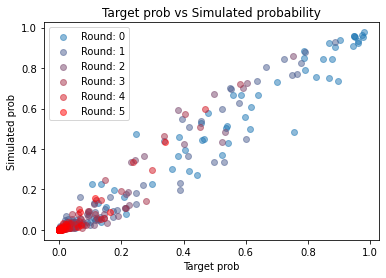

r2:  0.9419310428202152


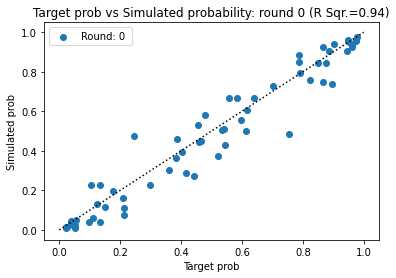

r2:  0.9236207231879234


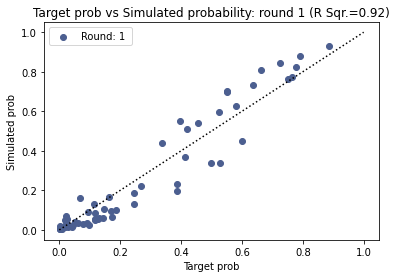

r2:  0.9133513867855072


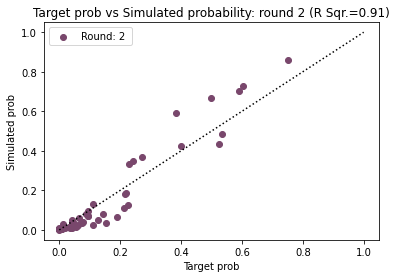

r2:  0.8963032141327858


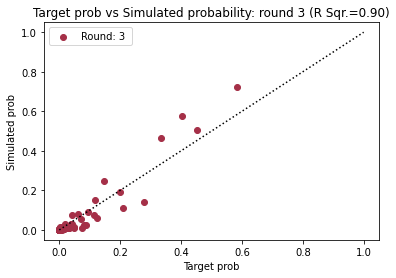

r2:  0.9154938459396362


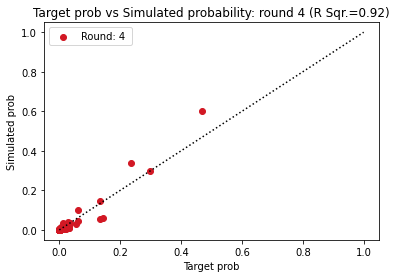

r2:  0.9003050178289413


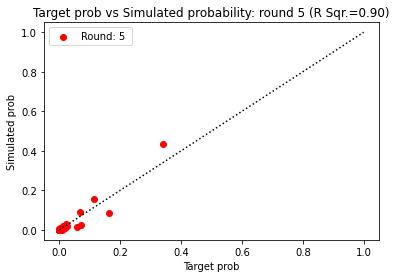

In [7]:
make_plots(TB,target, post_fix="pre_fit")

In [8]:
loss_func = nn.MSELoss()

In [19]:
optimizer = torch.optim.Adam([TB.ratings_tensor], lr=1e-4)
losses =[]

0 0.00011086505
100 0.00011086508
200 0.00011086502
300 0.00011086508
400 0.00011086501
500 0.000110865076
600 0.00011086504
700 0.000110865156
800 0.000110865105
900 0.000110865025


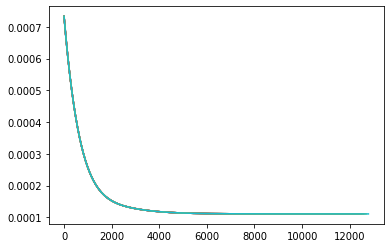

In [29]:
for i in range(1000):
    optimizer.zero_grad()
    prob = TB.prob_multi_level_flat()
    loss = loss_func(prob,target)
    loss.backward()
    losses.append(loss.detach().numpy())
    optimizer.step()
    if i%100==0:
        print(i,loss.detach().numpy())
        plt.plot(losses)
        #print(ratings_tensor)


In [30]:
TB.set_teams()

In [31]:
computer_rating = TB.starting_rating()
human_rating = TB.trained_rating()

In [32]:
names_prob = list(zip(names,computer_rating,human_rating,human_rating-computer_rating))
print("{},{},{},{}".format("Team", "Infered human rating", "Computer rating", "diff"))
for name, hr, tr, diff in sorted(names_prob,key=lambda x: -x[1]):
    print("{},{:.2f},{},{:.2f}".format(name, hr, tr, diff))

Team,Infered human rating,Computer rating,diff
Gonzaga,25.90,29.426183700561523,3.53
Baylor,23.10,23.670839309692383,0.57
Illinois,21.70,24.444913864135742,2.74
Iowa,20.90,21.1043643951416,0.20
Michigan,20.40,23.197738647460938,2.80
Houston,19.90,18.034740447998047,-1.87
Alabama,18.00,19.719558715820312,1.72
Villanova,17.90,15.617830276489258,-2.28
Ohio St.,17.50,19.693567276000977,2.19
Kansas,17.10,19.556270599365234,2.46
Creighton,16.90,14.931632995605469,-1.97
Texas Tech,16.90,13.993228912353516,-2.91
Florida St.,16.70,17.130107879638672,0.43
Texas,16.50,18.86070442199707,2.36
Tennessee,16.50,14.701680183410645,-1.80
Virginia,16.20,17.14564323425293,0.95
Arkansas,16.20,14.993257522583008,-1.21
West Virginia,16.20,17.716970443725586,1.52
Colorado,16.00,13.511459350585938,-2.49
USC,15.90,14.420269966125488,-1.48
Wisconsin,15.90,13.18616008758545,-2.71
Connecticut,15.20,12.68558120727539,-2.51
Purdue,15.20,13.968856811523438,-1.23
North Carolina,14.90,14.344351768493652,-0.56
LSU,14.60

r_squared:  0.9984496334800497


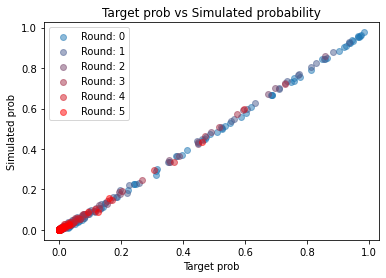

r2:  0.996922202873975


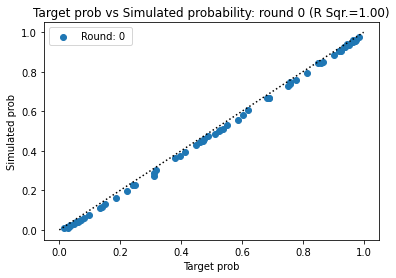

r2:  0.9983382211066782


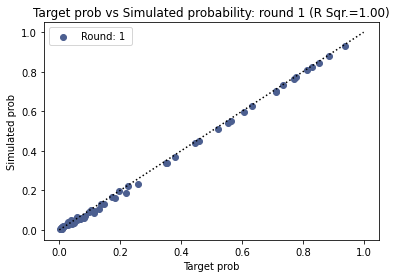

r2:  0.9985640519298613


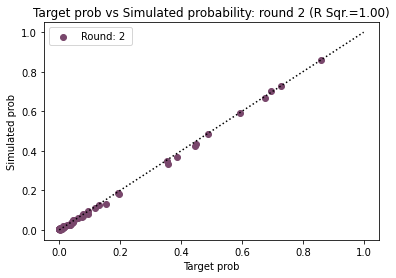

r2:  0.9980049079749733


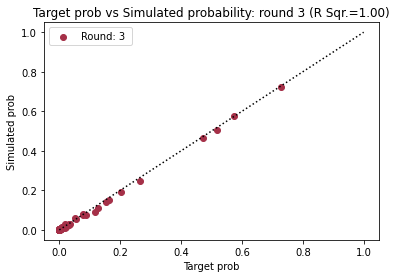

r2:  0.9948349865153432


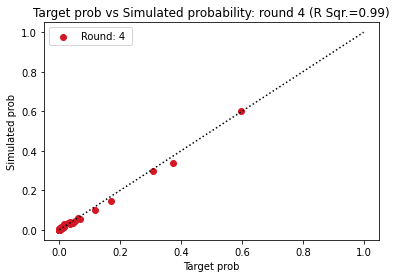

r2:  0.9889227440580726


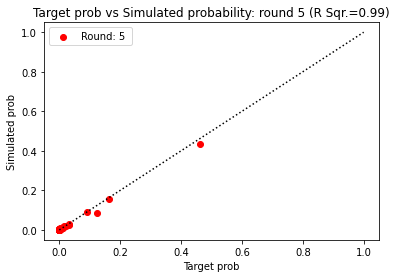

In [33]:
make_plots(TB,target, post_fix="post_fit")

In [34]:
with open("trained_bracket.pkl", 'wb') as f:
    pickle.dump(TB,f)

Demonstration of similarity between logistic vs norm cdf for 2*e base

In [35]:
from scipy.stats import norm

x = np.linspace(-20,20,100)
norm = norm.cdf(x, loc=0, scale=9.5)
logisitic = (1/(1+(e*2)**(-(x)/9.5) ) )

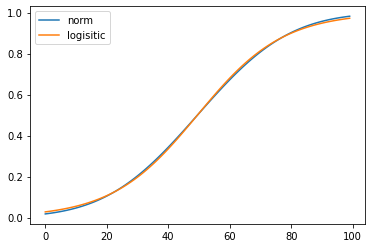

In [36]:
plt.plot(norm, label="norm")
plt.plot(logisitic, label="logisitic")
plt.legend()